# Credit Card Fraud Detection using Machine Learning

### Import libraries

In [17]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten, Activation, Input
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Import dataset (https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [18]:
df = pd.read_csv('../creditcard.csv')
df = df.dropna()
df = df.drop('Time', axis = 1)

### Investigate Class Sizes

In [19]:
groups = df.groupby('Class')

fraud = (groups.get_group(1).shape[0] / df.shape[0]) * 100
non_fraud = (groups.get_group(0).shape[0] / df.shape[0]) * 100

print('Percent Fraud: ' + str(fraud) + '%')
print('Percent Not Fraud ' + str(non_fraud) + '%')

Percent Fraud: 0.1727485630620034%
Percent Not Fraud 99.82725143693798%


### Split data into a train and holdout set

In [20]:
df_size = df.shape[0]
test_size = int(df_size * .3)
train_size = df_size - test_size

train_df = df.head(train_size)
test_df = df.tail(test_size)

X_train = train_df.drop('Class', axis = 1)
Y_train = train_df['Class']
X_test = test_df.drop('Class', axis = 1)
Y_test = test_df['Class']

### Apply a standard scalar to our data 

In [21]:
for feat in X_train.columns.values:
    X_train[feat] = StandardScaler().fit_transform(X_train[feat].values.reshape(-1,1))
    X_test[feat] = StandardScaler().fit_transform(X_test[feat].values.reshape(-1,1))

### Fit Random Forest Classifier

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

probabilities = rf.predict_proba(X_test)
y_pred_rf = probabilities[:,1]

### Evaluate Performance

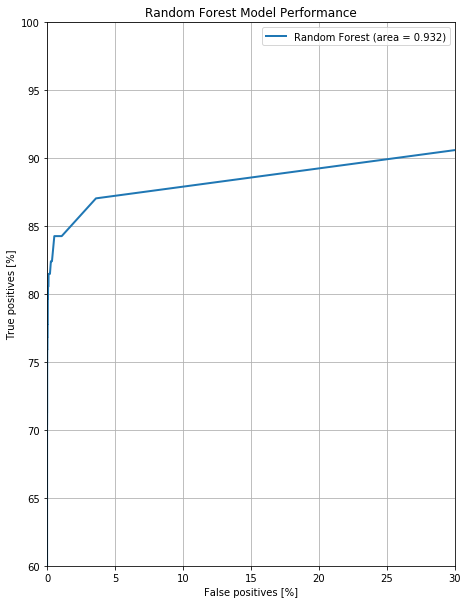

In [24]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(100*fpr_rf, 100*tpr_rf, label= 'Random Forest (area = {:.3f})'.format(auc_rf), linewidth=2, color = colors[0])
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([0,30])
plt.ylim([60,100])
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Random Forest Model Performance')
plt.legend(loc='best')

### Fit CatBoost Classifier

In [25]:
cat = CatBoostClassifier()
cat.fit(X_train, Y_train)
y_pred_cat = clf.predict(X_test, prediction_type='RawFormulaVal')

Learning rate set to 0.098829
0:	learn: 0.3988961	total: 39.2ms	remaining: 39.1s
1:	learn: 0.2094636	total: 73.5ms	remaining: 36.7s
2:	learn: 0.1171002	total: 103ms	remaining: 34.1s
3:	learn: 0.0679304	total: 139ms	remaining: 34.6s
4:	learn: 0.0426787	total: 172ms	remaining: 34.3s
5:	learn: 0.0271483	total: 208ms	remaining: 34.5s
6:	learn: 0.0175209	total: 238ms	remaining: 33.8s
7:	learn: 0.0125302	total: 267ms	remaining: 33.1s
8:	learn: 0.0094323	total: 300ms	remaining: 33s
9:	learn: 0.0074970	total: 332ms	remaining: 32.9s
10:	learn: 0.0061262	total: 362ms	remaining: 32.5s
11:	learn: 0.0051979	total: 396ms	remaining: 32.6s
12:	learn: 0.0045071	total: 436ms	remaining: 33.1s
13:	learn: 0.0040256	total: 479ms	remaining: 33.7s
14:	learn: 0.0037451	total: 512ms	remaining: 33.6s
15:	learn: 0.0034942	total: 542ms	remaining: 33.3s
16:	learn: 0.0033005	total: 571ms	remaining: 33s
17:	learn: 0.0031545	total: 602ms	remaining: 32.8s
18:	learn: 0.0030185	total: 631ms	remaining: 32.6s
19:	learn: 0.

### Evaluate perforamcne

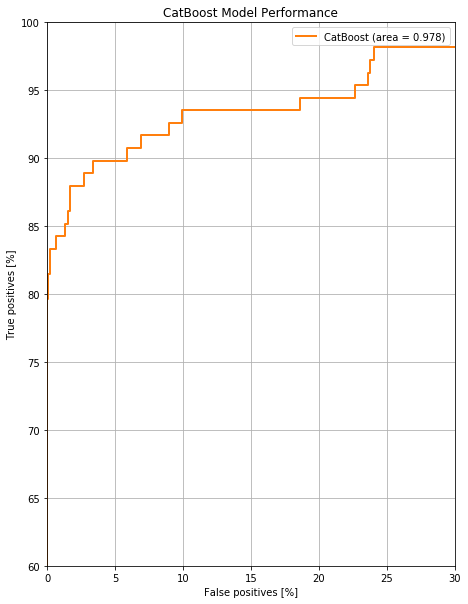

In [28]:
fpr_cat, tpr_cat, thresholds_cat = roc_curve(Y_test, y_pred_cat)
auc_cat = auc(fpr_cat, tpr_cat)

plt.plot(100*fpr_cat, 100*tpr_cat, label= 'CatBoost (area = {:.3f})'.format(auc_cat), linewidth=2, color = colors[1])
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([0,30])
plt.ylim([60,100])
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
plt.title('CatBoost Model Performance')
plt.legend(loc='best')

In [29]:
#Design and compile model
DNN = Sequential()
DNN.add(Input(shape=(X_train.shape[1],)))
DNN.add(Dense(100, activation='relu'))
DNN.add(Dropout(0.5))
DNN.add(Dense(100, activation='relu'))
DNN.add(Dropout(0.5))
DNN.add(Dense(10, activation='relu'))
DNN.add(Dense(1, activation='sigmoid'))
DNN.compile(loss='binary_crossentropy', optimizer='adam', metrics = keras.metrics.AUC(name='auc'))

#fit model
DNN.fit(X_train, Y_train, epochs=10)

#generate prediction probabilities on test data
y_pred_DNN = DNN.predict(X_test).ravel()

Epoch 1/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0094 - auc: 0.8841
Epoch 2/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0050 - auc: 0.9292
Epoch 3/10
6231/6231 [==============================] - 8s 1ms/step - loss: 0.0044 - auc: 0.9440
Epoch 4/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0040 - auc: 0.9440
Epoch 5/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0037 - auc: 0.9454
Epoch 6/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0038 - auc: 0.9494
Epoch 7/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0036 - auc: 0.9533
Epoch 8/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0035 - auc: 0.9495
Epoch 9/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0038 - auc: 0.9455
Epoch 10/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0034 - auc: 0.9561


### Evaluate Performance

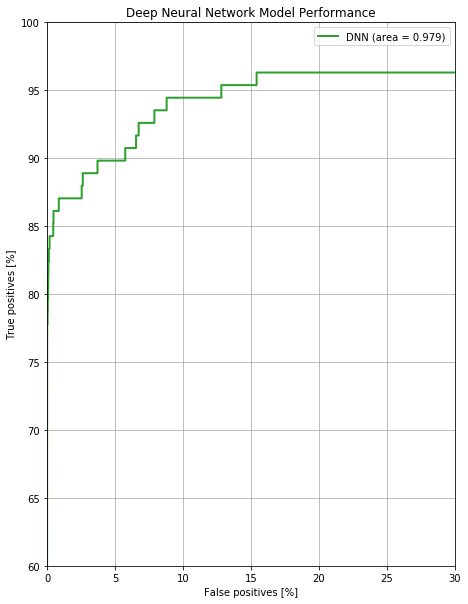

In [35]:
fpr_DNN, tpr_DNN, thresholds_DNN = roc_curve(Y_test, y_pred_DNN)
auc_DNN = auc(fpr_DNN, tpr_DNN)

name = 'DNN'
plt.plot(100*fpr_DNN, 100*tpr_DNN, label= 'DNN (area = {:.3f})'.format(auc_DNN), linewidth=2, color = colors[2])
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([0,30])
plt.ylim([60,100])
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Deep Neural Network Model Performance')
plt.legend(loc='best')

In [36]:
iforest = IsolationForest()
iforest.fit(X_train)

y_pred_iforest = - iforest.decision_function(X_test)

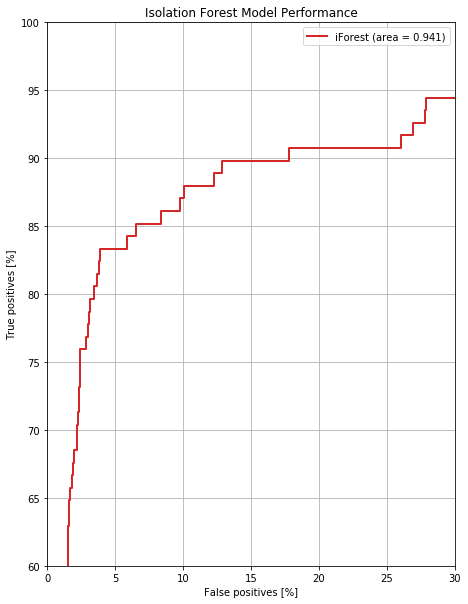

In [37]:
fpr_iforest, tpr_iforest, thresholds__iforest = roc_curve(Y_test, y_pred_iforest)
auc_iforest = auc(fpr_iforest, tpr_iforest)

plt.plot(100*fpr_iforest, 100*tpr_iforest, label= 'iForest (area = {:.3f})'.format(auc_iforest), linewidth=2, color = colors[3])
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([0,30])
plt.ylim([60,100])
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Isolation Forest Model Performance')
plt.legend(loc='best')